In [1]:
import sys
sys.path.append('..')

In [2]:
import os
from pathlib import Path
import numpy as np
import pywt
import wfdb
from numpy.random import choice, shuffle
from matplotlib import pyplot as plt
from CommonFunctions import *
%matplotlib inline

In [3]:
svdb_dir = Path('./svdb_dir')
svdb_files = [os.path.splitext(f)[0] for f in os.listdir(svdb_dir) if f.endswith('.dat')]
print(svdb_files)

['800', '801', '802', '803', '804', '805', '806', '807', '808', '809', '810', '811', '812', '820', '821', '822', '823', '824', '825', '826', '827', '828', '829', '840', '841', '842', '843', '844', '845', '846', '847', '848', '849', '850', '851', '852', '853', '854', '855', '856', '857', '858', '859', '860', '861', '862', '863', '864', '865', '866', '867', '868', '869', '870', '871', '872', '873', '874', '875', '876', '877', '878', '879', '880', '881', '882', '883', '884', '885', '886', '887', '888', '889', '890', '891', '892', '893', '894']


In [4]:
time_window = 40
all_beats = []
all_annotations = []
for in_file in svdb_files:
    annotations = wfdb.rdann(str(os.path.join(svdb_dir, in_file)), 'atr')
    ann_symbols = annotations.symbol[5:-5]
    ann_locations = annotations.sample[5:-5]
    signal, fields = wfdb.rdsamp(str(os.path.join(svdb_dir, in_file)), channels=[0])
    signal = signal.flatten()
    for symbol, location in zip(ann_symbols, ann_locations):
        if symbol in ['N', 'S', 'V']:
            all_beats.append(signal[location - time_window: location + time_window])
            all_annotations.append(symbol)
all_beats = np.vstack(all_beats)
all_annotations = np.array(all_annotations)
print(all_beats.shape, all_annotations.shape)
print('no of N beats: ' + str(np.count_nonzero(all_annotations == 'N')))
print('no of S beats: ' + str(np.count_nonzero(all_annotations == 'S')))
print('no of V beats: ' + str(np.count_nonzero(all_annotations == 'V')))

(183707, 80) (183707,)
no of N beats: 161653
no of S beats: 12146
no of V beats: 9908


In [5]:
def randomly_pick_indexes(labels: np.array, quantity: int, proportions: dict[str, float]):
    group_labels = list(proportions.keys())
    group_proportions = [round(quantity * p) for p in proportions.values()]
    picks = []
    for label, proportion in zip(group_labels, group_proportions):
        group = np.where(labels == label)[0]
        picks.append(choice(group, size=proportion, replace=False))
    picks = np.hstack(picks)
    shuffle(picks)
    return picks

def plot_random_beats(beats, beat_annotations, size, proportions, title=None, file=None):
    colors = {'N': 'lime', 'S': 'blue', 'V': 'red'}
    with plt.style.context('cyberpunk'):
        figure, axes = plt.subplots(*size, layout='constrained', figsize=(12, 12))
        fontsize = figure.axes[0].get_window_extent().transformed(figure.dpi_scale_trans.inverted())
        fontsize = fontsize.width * 0.15 * figure.dpi
        random_ann_labels = randomly_pick_indexes(beat_annotations, size[0] * size[1], proportions)
        for ax, random_index in zip(figure.axes, random_ann_labels):
            ax.plot(beats[random_index], color=colors[beat_annotations[random_index]])
            ax.text(x=0.02, y=0.98, s=f'{beat_annotations[random_index]}',
                    transform=ax.transAxes, fontweight='bold', fontsize=fontsize)
            ax.axis(False)
            enhance_plot(figure, ax, glow=True, alpha_gradient=0.8, dpi=150)
        figure.suptitle(title, )
    if file is None:
        figure.savefig(f'images/random_beat_images{"x".join([str(coord) for coord in size])}.png')
    else:
        figure.savefig(f'images/{file}.png')

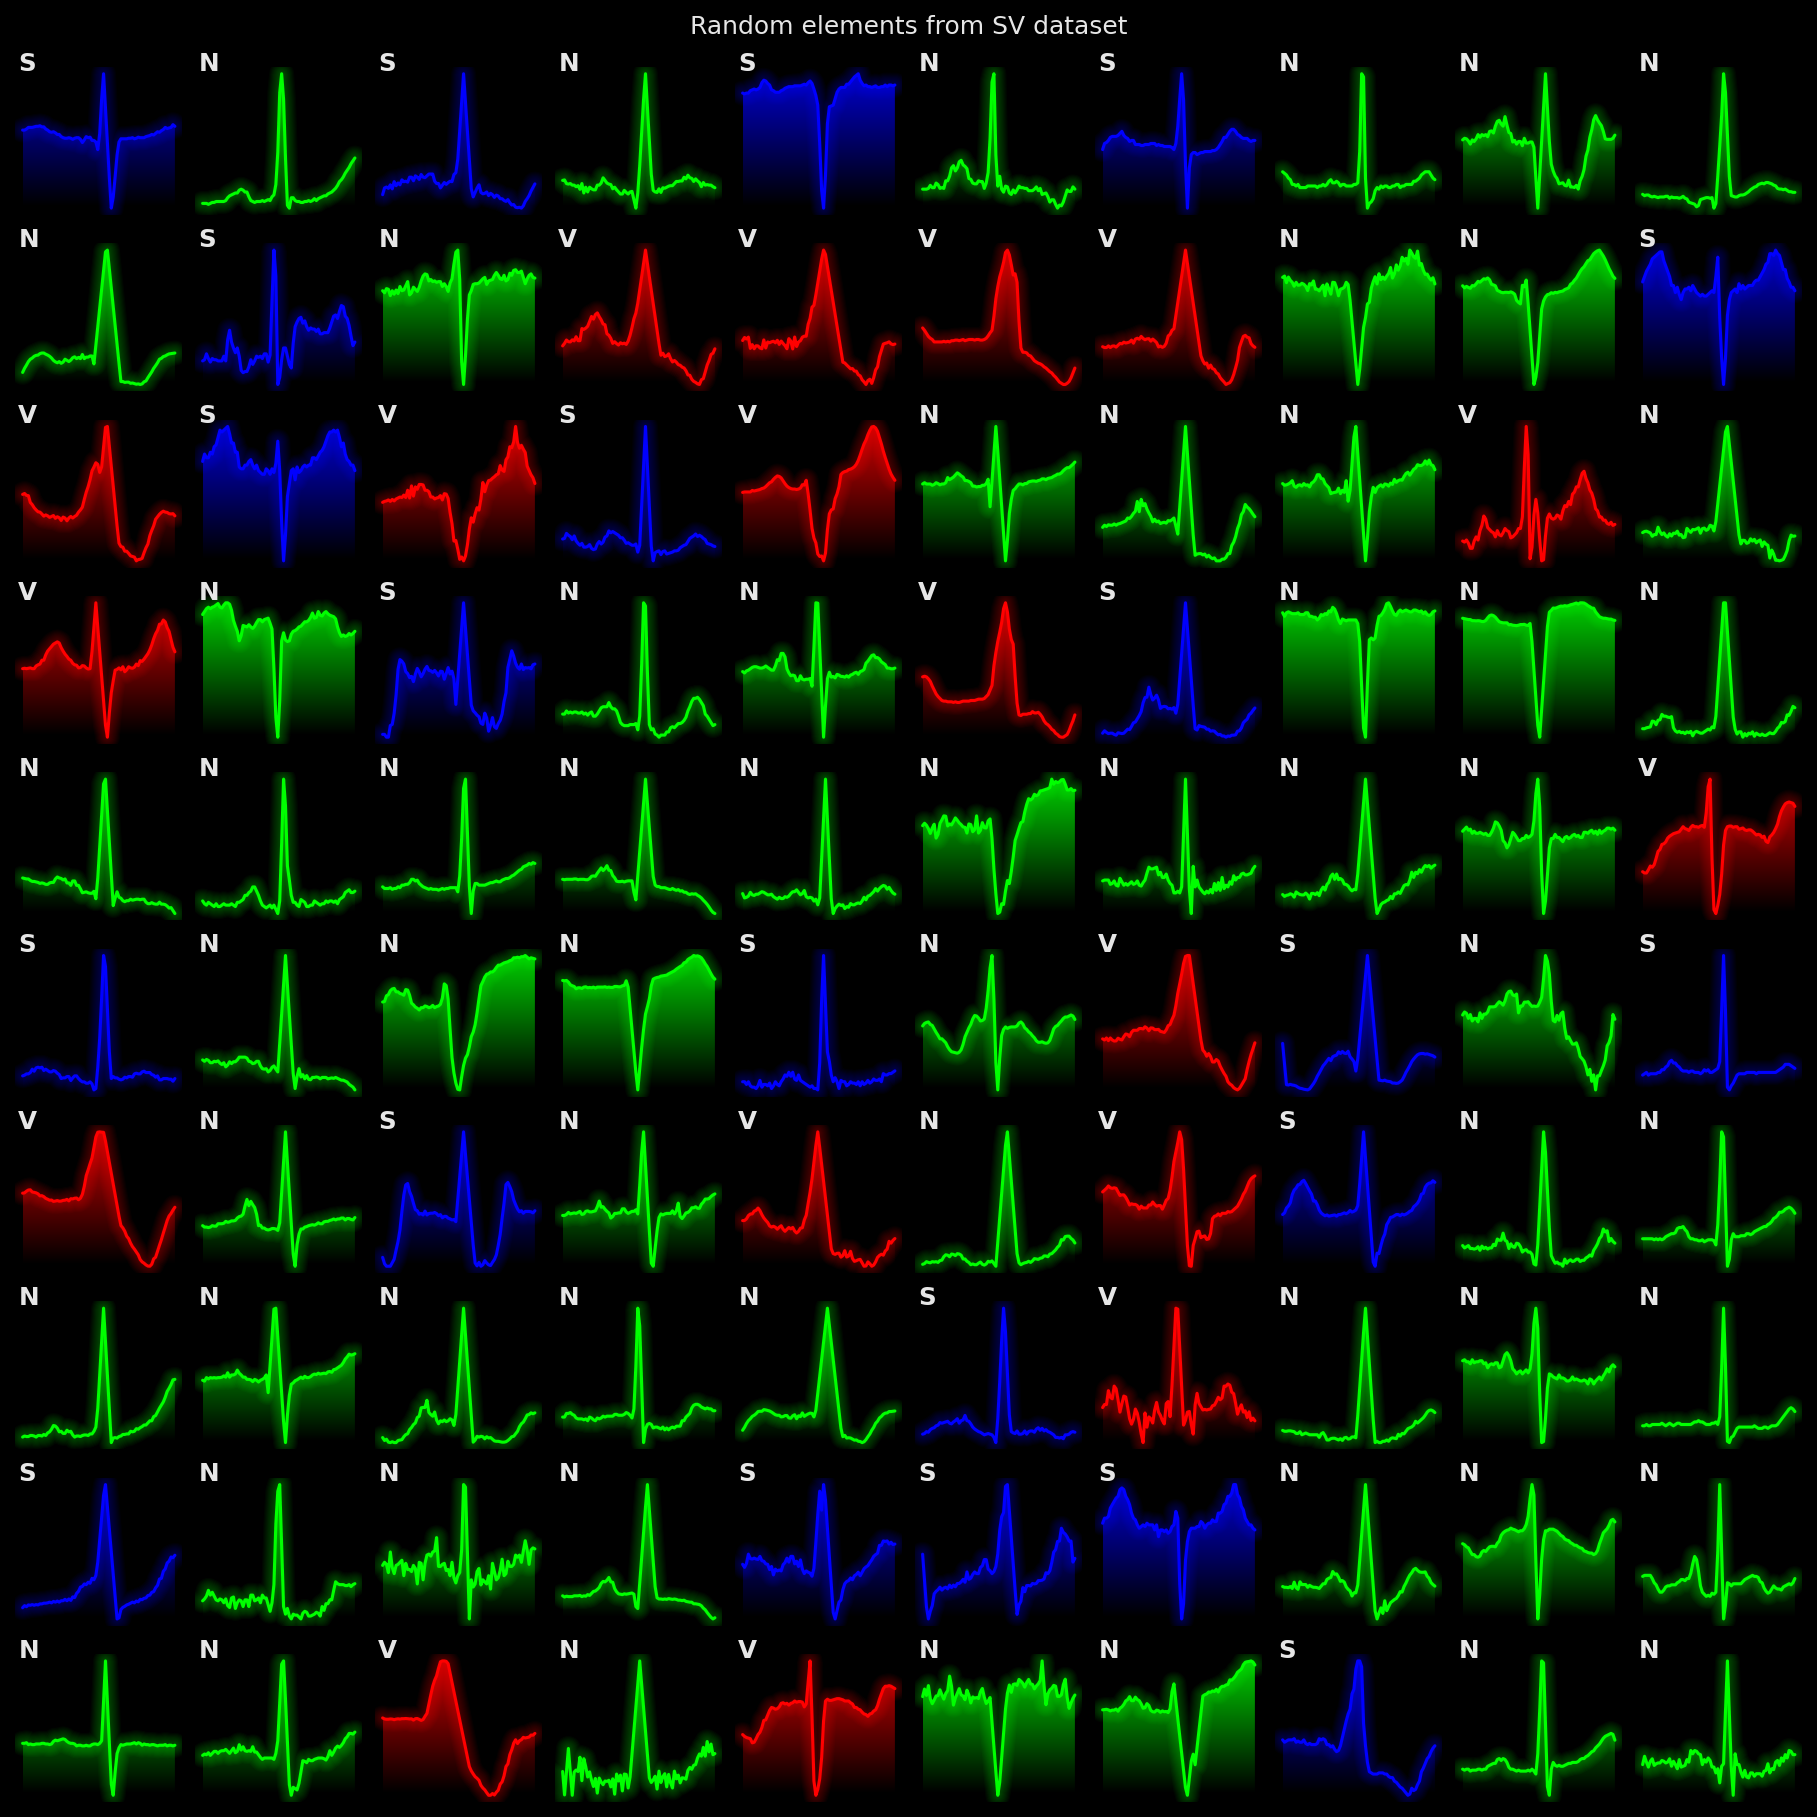

In [6]:
fig_title = 'Random elements from SV dataset'
props = {'N': 0.6, 'S': 0.22, 'V': 0.18}
plot_random_beats(all_beats, all_annotations, (10, 10), props, title=fig_title)

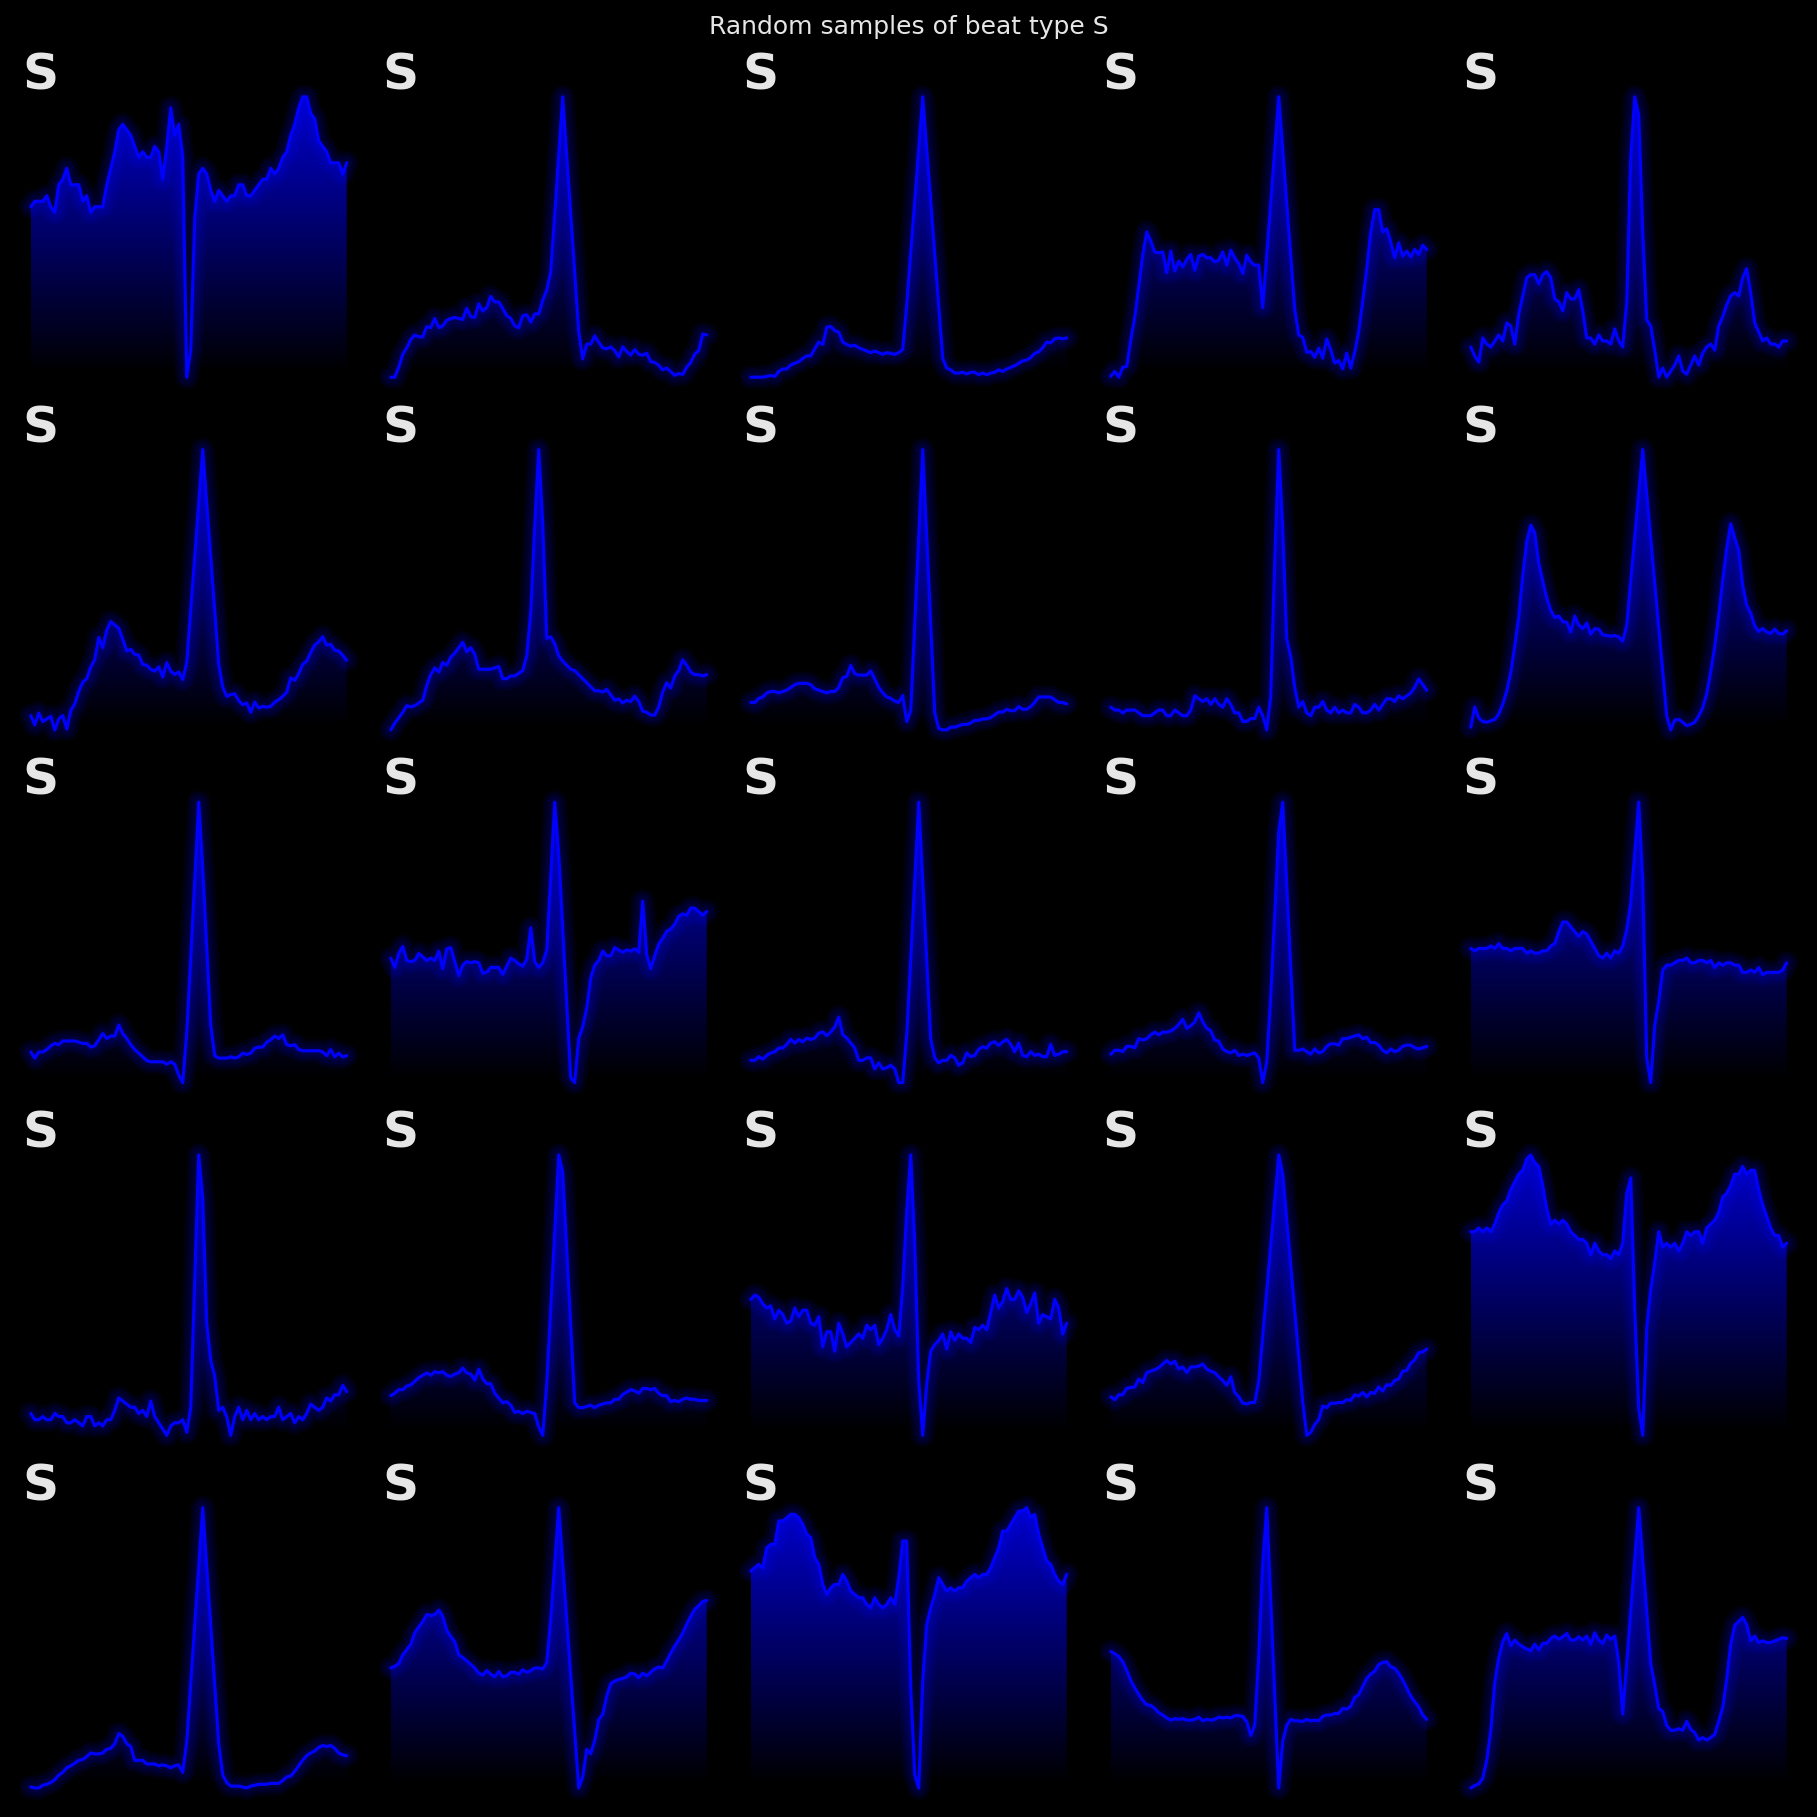

In [7]:
fig_title = 'Random samples of beat type S'
props = {'N': 0., 'S': 1., 'V': 0.}
plot_random_beats(all_beats, all_annotations, (5, 5), props, title=fig_title, file='typeS')

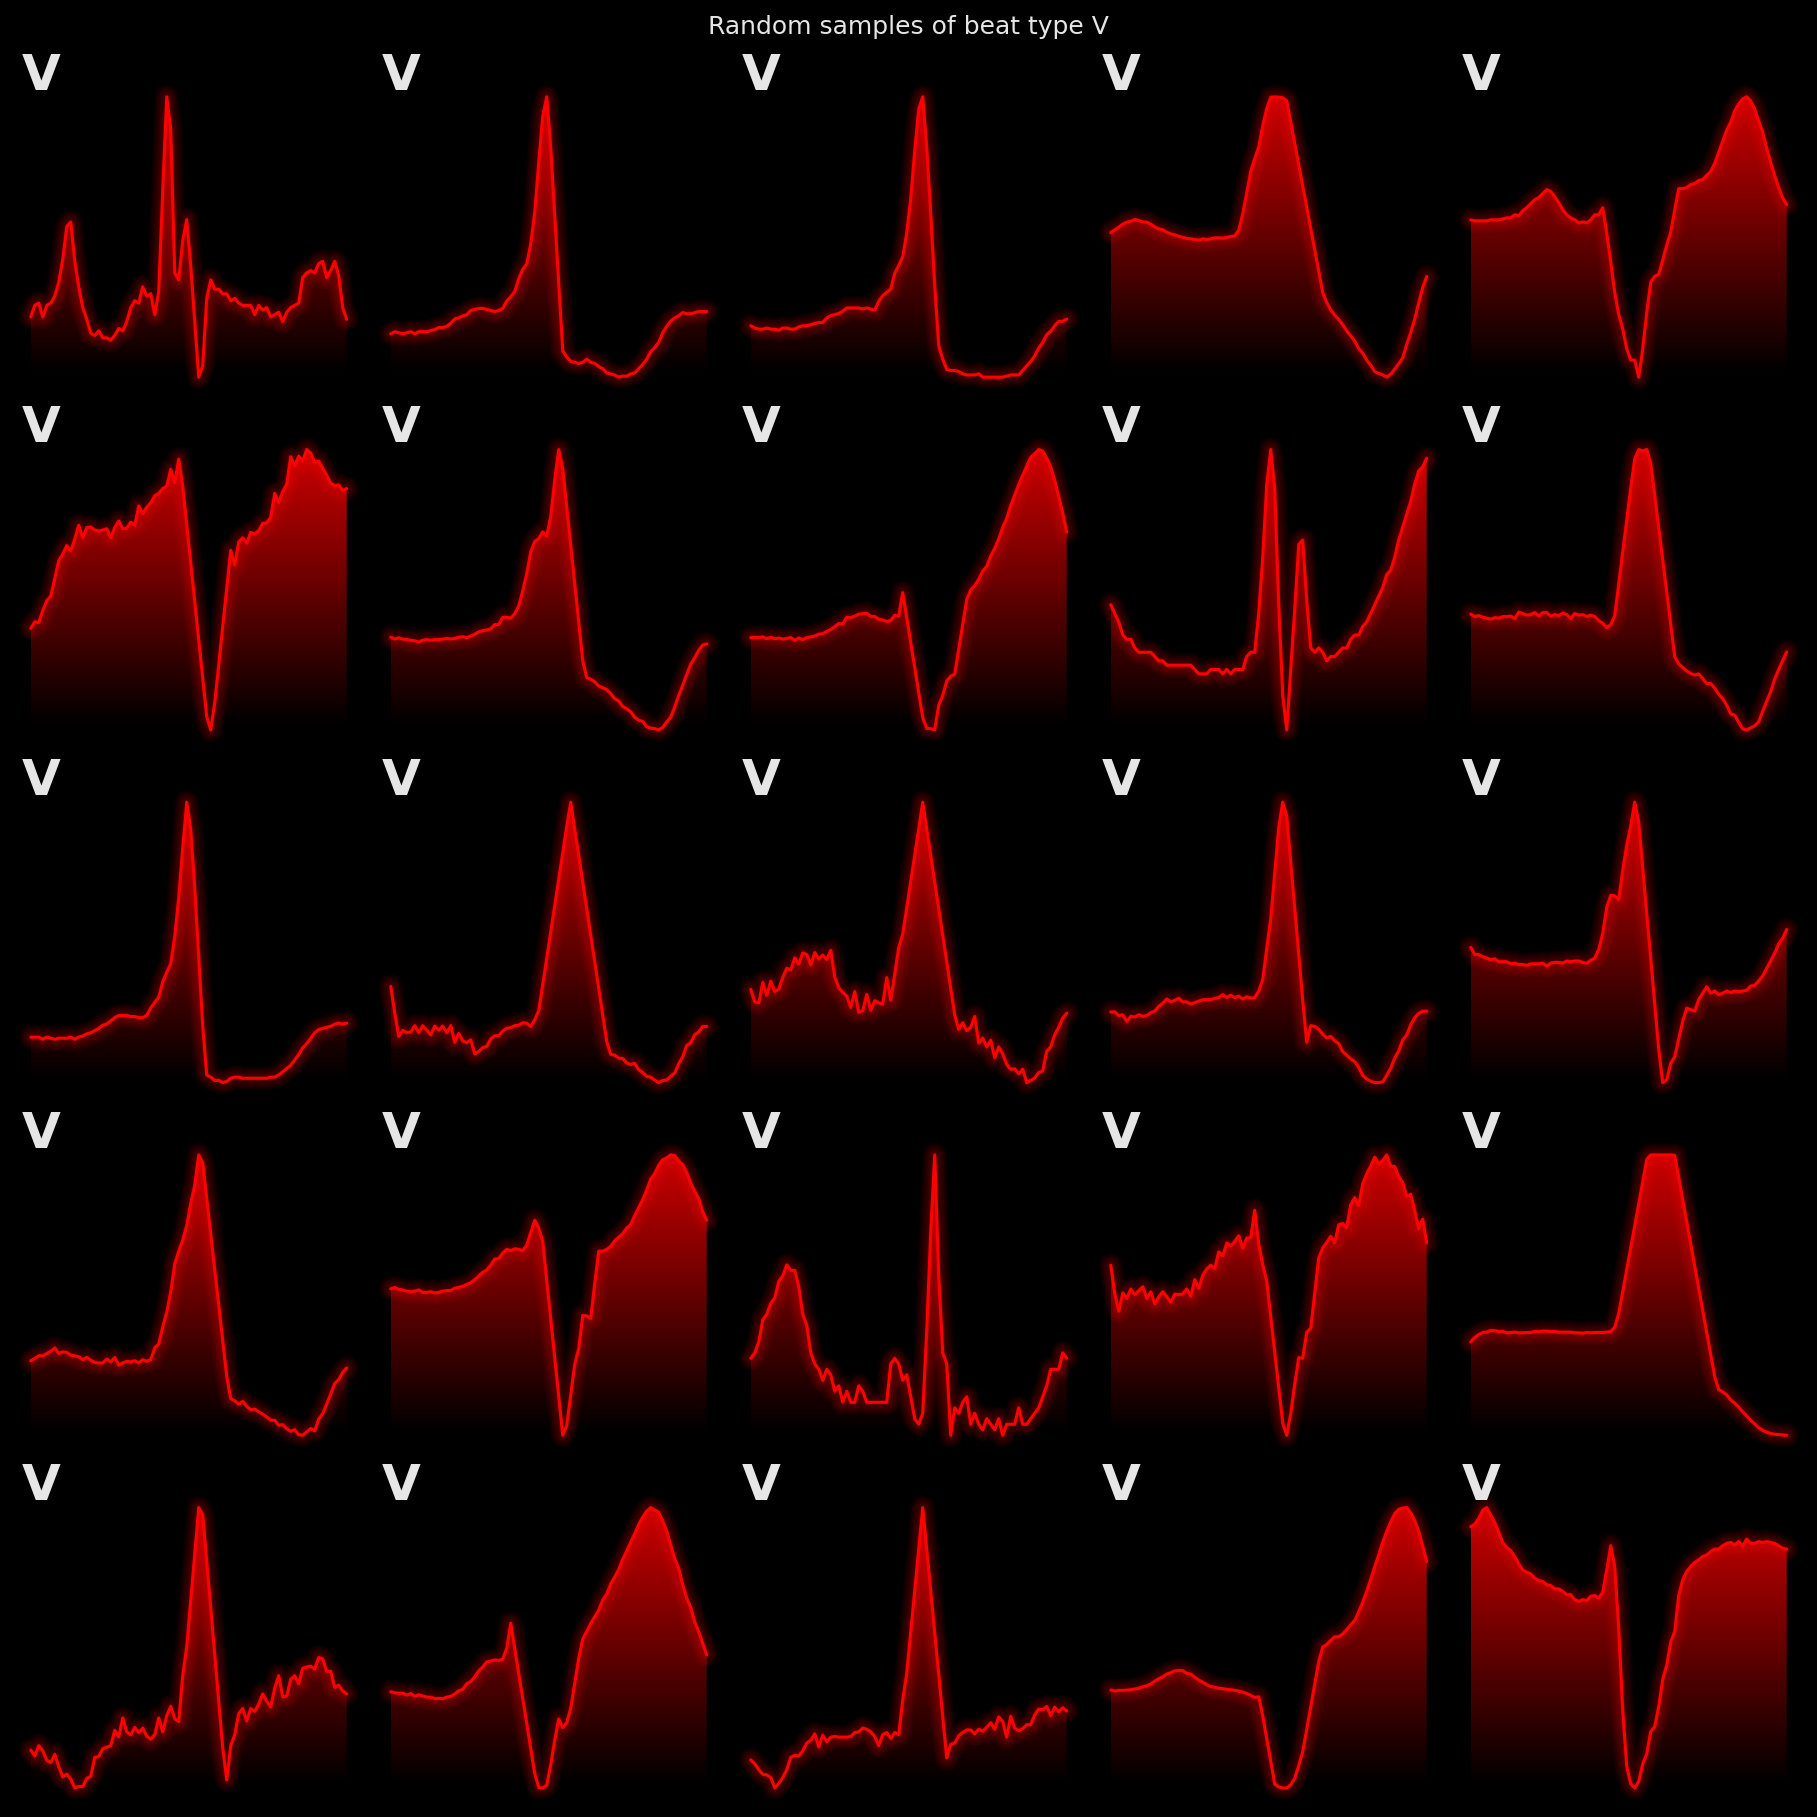

In [8]:
fig_title = 'Random samples of beat type V'
props = {'N': 0., 'S': 0., 'V': 1.}
plot_random_beats(all_beats, all_annotations, (5, 5), props, title=fig_title, file='typeV')